In [136]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana as pdna
import os
from tqdm import tqdm

In [137]:
#amenities_with_neighborhood.to_file("amenities_with_neighborhood.geojson", driver='GeoJSON')
amenities_with_neighborhood = gpd.read_file('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/dataframes/amenities_with_neighborhood.geojson')

In [138]:
neighbourhoods = list(amenities_with_neighborhood['Arrondissement'].unique())[:-1]
neighbourhoods = [neighborhood + ', Montreal, Canada' for neighborhood in neighbourhoods]

In [139]:
place = 'Montreal, Canada'
type_of_transportation = 'walk'
tags = {'shop': ['grocery', 'greengrocer', 'supermarket']}
#tags = {'amenity': ['hospital']}
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

In [140]:
amenities = ox.geometries_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
#centroids = amenities.centroid

/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_1810/84965001.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  amenities = ox.geometries_from_place(place, tags=tags)


In [143]:
amenities.head(5)

name         shop  \
element_type osmid                                           
node         189770195                 Sharmi  supermarket   
             221063335                Provigo  supermarket   
             237578368         PA Supermarché  supermarket   
             237578374  PA Nature Supermarché  supermarket   
             424780619                    IGA  supermarket   

                                                geometry    brand  \
element_type osmid                                                  
node         189770195  POINT (-4968194.738 9204111.844)      NaN   
             221063335  POINT (-4972624.682 9192364.858)  Provigo   
             237578368  POINT (-4975354.874 9193018.109)      NaN   
             237578374  POINT (-4971461.402 9195128.873)      NaN   
             424780619  POINT (-4972634.397 9191423.556)      IGA   

                       brand:wikidata        brand:wikipedia  check_date  \
element_type osmid                                                         
node         189770195            NaN                    NaN         NaN   
             221063335       Q3408306             en:Provigo  2023-09-22   
             237578368            NaN                    NaN         NaN   
             237578374            NaN                    NaN         NaN   
             424780619       Q3146662  en:IGA (supermarkets)         NaN   

                            opening_hours payment:apple_pay payment:cash  ...  \
element_type osmid                                                        ...   
node         189770195                NaN               NaN          NaN  ...   
             221063335  Mo-Su 08:00-23:00               yes          yes  ...   
             237578368  Mo-Su 08:00-22:00               NaN          NaN  ...   
             237578374                NaN               NaN          NaN  ...   
             424780619        08:00-21:00               NaN          NaN  ...   

                       payment:notes roof:levels roof:shape toilets architect  \
element_type osmid                                                              
node         189770195           NaN         NaN        NaN     NaN       NaN   
             221063335           NaN         NaN        NaN     NaN       NaN   
             237578368           NaN         NaN        NaN     NaN       NaN   
             237578374           NaN         NaN        NaN     NaN       NaN   
             424780619           NaN         NaN        NaN     NaN       NaN   

                       building:material roof:material wikidata  url indoor  
element_type osmid                                                           
node         189770195               NaN           NaN      NaN  NaN    NaN  
             221063335               NaN           NaN      NaN  NaN    NaN  
             237578368               NaN           NaN      NaN  NaN    NaN  
             237578374               NaN           NaN      NaN  NaN    NaN  
             424780619               NaN           NaN      NaN  NaN    NaN  

[5 rows x 98 columns]

In [121]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

# graphs = {}

# # specify parameters for the analysis
# walk_time = 15  # max walking horizon in minutes
# walk_speed = 5  # km per hour
# walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# # Loop through the neighborhoods
# for neighborhood in tqdm(neighbourhoods):
#     # Create a graph for the current neighborhood
#     G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type='walk') # type of transportation is set here

#     for u, v, data in G_walk_neighborhood.edges(data=True):
#         data['speed_kph'] = walk_speed
#     G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# # caro path
#     # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# # michel path
#     ox.save_graphml(G_walk_neighborhood, f"../graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
#     # Store the graph in the dictionary using the neighborhood name as the key
#     graphs[neighborhood] = G_walk_neighborhood

In [122]:
graphs = {}
graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/graphs'

for file_name in os.listdir(graphs_dir):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)

        graphs[neighborhood] = G_walk_neighborhood


In [123]:
pandanas = {}

if pandanas == {}:
    # Build Pandana network for each neighborhood
    for neighborhood, graph in tqdm(graphs.items()):
        graph = ox.project_graph(graph, to_crs='EPSG:25832')
        nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
        edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

        network = pdna.Network(node_x=nodes['x'],
                                node_y=nodes['y'], 
                                edge_from=edges['u'],
                                edge_to=edges['v'],
                                edge_weights=edges[['travel_time']])
        for amenity in tags:
            pandanas[neighborhood][amenity] = network

  6%|▌         | 1/18 [00:07<02:02,  7.19s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:17<02:25,  9.08s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:29<02:38, 10.57s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:32<01:45,  7.50s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:37<01:26,  6.62s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:44<01:20,  6.74s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:47<00:58,  5.32s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:48<00:41,  4.14s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:50<00:30,  3.43s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:54<00:28,  3.60s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 61%|██████    | 11/18 [01:01<00:32,  4.71s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [01:09<00:34,  5.75s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [01:10<00:21,  4.22s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [01:21<00:24,  6.10s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [01:22<00:14,  4.79s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [01:34<00:13,  6.81s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [01:35<00:05,  5.00s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [01:40<00:00,  5.57s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [134]:
  # Initialize dictionary for the current amenity
for neighborhood, pandana in tqdm(pandanas.items()):
    pandana.set_pois(category='hospital',
                    maxdist=walk_time_sec,
                    maxitems=3,
                    x_col=centroids.x,
                    y_col=centroids.y)
        
    distances_hospital = pandana.nearest_pois(distance=walk_time_sec,
                                         category='hospital',
                                         num_pois=3)
        
    distances_hospital['travel_time'] = distances_hospital[1] / 60
    walking_distances_hospital = distances_hospital

  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
  0%|          | 0/18 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [128]:
walking_distances_parking.head()

,1,2,3,travel_time
osmid,,,,
32662002,156.000000,180.199997,210.699997,2.600000
8540714637,150.399994,174.600006,205.100006,2.506667
8540714635,161.300003,185.500000,216.000000,2.688333
8540714636,152.300003,176.500000,207.000000,2.538333
32662023,42.799999,163.500000,227.100006,0.713333


In [127]:
walking_distances_hospital

,1,2,3,travel_time
osmid,,,,
32662002,900.000000,900.0,900.0,15.000000
8540714637,900.000000,900.0,900.0,15.000000
8540714635,900.000000,900.0,900.0,15.000000
8540714636,900.000000,900.0,900.0,15.000000
32662023,900.000000,900.0,900.0,15.000000
...,...,...,...,...
11645973591,399.799988,900.0,900.0,6.663333
11647267752,636.900024,900.0,900.0,10.615000
11647267753,637.400024,900.0,900.0,10.623334


In [108]:
amenities_of_interest = ['parking', 'hospital']

walking_distances = {}  # Dictionary to store walking distances for each amenity

for amenity in amenities_of_interest:
    walking_distances[amenity] = {}  # Initialize dictionary for the current amenity
    
    for neighborhood, pandana in tqdm(pandanas.items()):
        print('Calculating distances for: ', amenity)
        print('Calculating distances for: ', neighborhood)
        pandana.set_pois(category=amenity,
                         maxdist=walk_time_sec,
                         maxitems=3,
                         x_col=centroids.x,
                         y_col=centroids.y)
        
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                         category=amenity,
                                         num_pois=3)
        
        distances['travel_time'] = distances[1] / 60
        walking_distances[amenity][neighborhood] = distances

  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Mercier–Hochelaga-Maisonneuve, Montreal, Canada


  6%|▌         | 1/18 [00:00<00:11,  1.54it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada


 11%|█         | 2/18 [00:01<00:11,  1.41it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Rosemont–La Petite-Patrie, Montreal, Canada


 17%|█▋        | 3/18 [00:01<00:09,  1.53it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 22%|██▏       | 4/18 [00:02<00:06,  2.24it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  parking
Calculating distances for:  Outremont, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  Le Sud-Ouest, Montreal, Canada


 28%|██▊       | 5/18 [00:02<00:05,  2.37it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Saint-Laurent, Montreal, Canada


 33%|███▎      | 6/18 [00:02<00:04,  2.53it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 39%|███▉      | 7/18 [00:03<00:03,  3.07it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  parking
Calculating distances for:  Verdun, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  Anjou, Montreal, Canada


 44%|████▍     | 8/18 [00:03<00:02,  3.62it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 50%|█████     | 9/18 [00:03<00:02,  4.07it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  parking
Calculating distances for:  Saint-Léonard, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  Lachine, Montreal, Canada


 56%|█████▌    | 10/18 [00:03<00:01,  4.36it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Villeray–Saint-Michel–Parc-Extension, Montreal, Canada


 61%|██████    | 11/18 [00:03<00:01,  3.52it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  parking
Calculating distances for:  Le Plateau-Mont-Royal, Montreal, Canada


 67%|██████▋   | 12/18 [00:05<00:03,  1.54it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: Fut

Calculating distances for:  parking
Calculating distances for:  L'Île_Bizard_Sainte_Geneviève, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  Ville-Marie, Montreal, Canada


 78%|███████▊  | 14/18 [00:05<00:01,  2.13it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 83%|████████▎ | 15/18 [00:06<00:01,  2.62it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/p

Calculating distances for:  parking
Calculating distances for:  Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  Ahuntsic-Cartierville, Montreal, Canada


 89%|████████▉ | 16/18 [00:06<00:00,  2.42it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: Fut

Calculating distances for:  parking
Calculating distances for:  Montréal-Nord, Montreal, Canada
Calculating distances for:  parking
Calculating distances for:  LaSalle, Montreal, Canada


  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Mercier–Hochelaga-Maisonneuve, Montreal, Canada


  6%|▌         | 1/18 [00:00<00:06,  2.82it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada


 11%|█         | 2/18 [00:00<00:06,  2.54it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Rosemont–La Petite-Patrie, Montreal, Canada


 17%|█▋        | 3/18 [00:01<00:06,  2.20it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 22%|██▏       | 4/18 [00:01<00:04,  3.01it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  hospital
Calculating distances for:  Outremont, Montreal, Canada
Calculating distances for:  hospital
Calculating distances for:  Le Sud-Ouest, Montreal, Canada


 28%|██▊       | 5/18 [00:01<00:04,  2.79it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Saint-Laurent, Montreal, Canada


 33%|███▎      | 6/18 [00:02<00:03,  3.01it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 39%|███▉      | 7/18 [00:02<00:03,  3.61it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  hospital
Calculating distances for:  Verdun, Montreal, Canada
Calculating distances for:  hospital
Calculating distances for:  Anjou, Montreal, Canada


 44%|████▍     | 8/18 [00:02<00:02,  4.10it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
 50%|█████     | 9/18 [00:02<00:01,  4.70it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/pyt

Calculating distances for:  hospital
Calculating distances for:  Saint-Léonard, Montreal, Canada
Calculating distances for:  hospital
Calculating distances for:  Lachine, Montreal, Canada


 56%|█████▌    | 10/18 [00:02<00:01,  5.29it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Villeray–Saint-Michel–Parc-Extension, Montreal, Canada


 61%|██████    | 11/18 [00:03<00:01,  3.93it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Le Plateau-Mont-Royal, Montreal, Canada


 67%|██████▋   | 12/18 [00:03<00:01,  3.30it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: Fut

Calculating distances for:  hospital
Calculating distances for:  L'Île_Bizard_Sainte_Geneviève, Montreal, Canada
Calculating distances for:  hospital
Calculating distances for:  Ville-Marie, Montreal, Canada


 78%|███████▊  | 14/18 [00:04<00:01,  3.62it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada


 83%|████████▎ | 15/18 [00:04<00:00,  3.48it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Calculating distances for:  hospital
Calculating distances for:  Ahuntsic-Cartierville, Montreal, Canada


 89%|████████▉ | 16/18 [00:04<00:00,  3.00it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: Fut

Calculating distances for:  hospital
Calculating distances for:  Montréal-Nord, Montreal, Canada
Calculating distances for:  hospital
Calculating distances for:  LaSalle, Montreal, Canada


100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


In [109]:
walking_distances['parking']['Ahuntsic-Cartierville, Montreal, Canada']['travel_time'].mean()

2.0428066037254604

In [110]:
walking_distances['hospital']['Ahuntsic-Cartierville, Montreal, Canada']['travel_time'].mean()

2.0428066037254604

In [26]:
walking_distances['school']['Anjou, Montreal, Canada']['travel_time'].mean()

5.172074941865867

In [29]:
df = pd.DataFrame(walking_distances) # Now df contains all the walking distances for each amenity in each neighborhood
neighborhood = 'Mercier–Hochelaga-Maisonneuve, Montreal, Canada'
amenity = 'restaurant'

# Filter the DataFrame based on the specified neighborhood and amenity
filtered_distances = df.loc[neighborhood, amenity]

In [30]:
#all_distances_walk = pd.concat([df.assign(neighborhood=name) for name, df in walking_distances.items()], ignore_index=True)
#all_distances_walk = all_distances_walk.sort_values(by='travel_time')
#all_distances_walk.to_csv('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/distances/all_distances_bike.csv', index=False) 

In [36]:
G_walk_anjou = graphs['Anjou, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Anjou, Montreal, Canada'] # access one pandana network
distances_anjou_restaurant = filtered_distances = df.loc['Anjou, Montreal, Canada', 'restaurant']

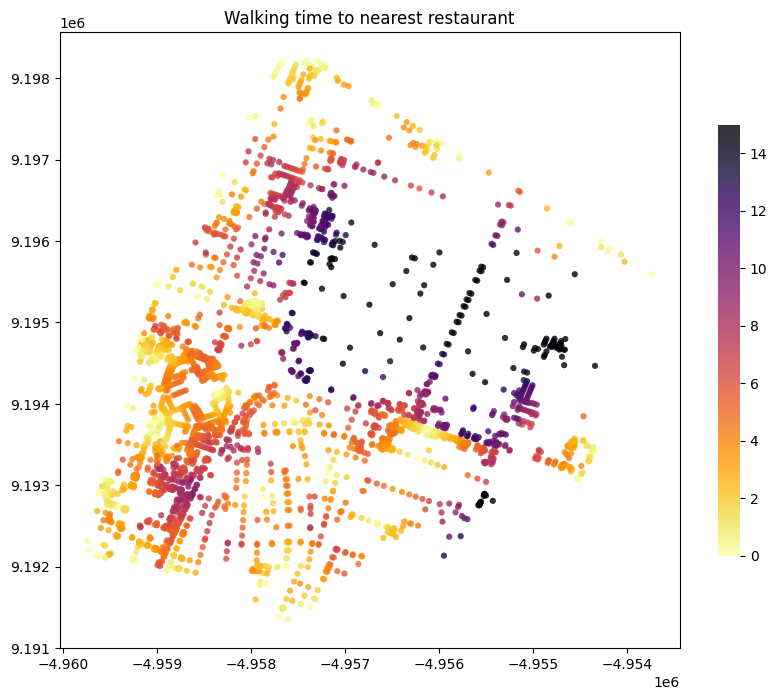

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot distance to nearest amenity from each node
# ox.plot_graph(G_walk_anjou, ax=ax, node_size=0, edge_linewidth=0.1,
#                         edge_color='gray', show=False, close=False)

nodes_anjou = pandana_anjou.nodes_df[['x', 'y']]

sc = ax.scatter(x=nodes_anjou['x'],
                y=nodes_anjou['y'], 
                c=distances_anjou_restaurant['travel_time'], # column to plot (distance to nearest store)
                s=20, # size
                cmap='inferno_r',
                edgecolors='none',
                alpha=0.8)

ax.set_title('Walking time to nearest restaurant')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

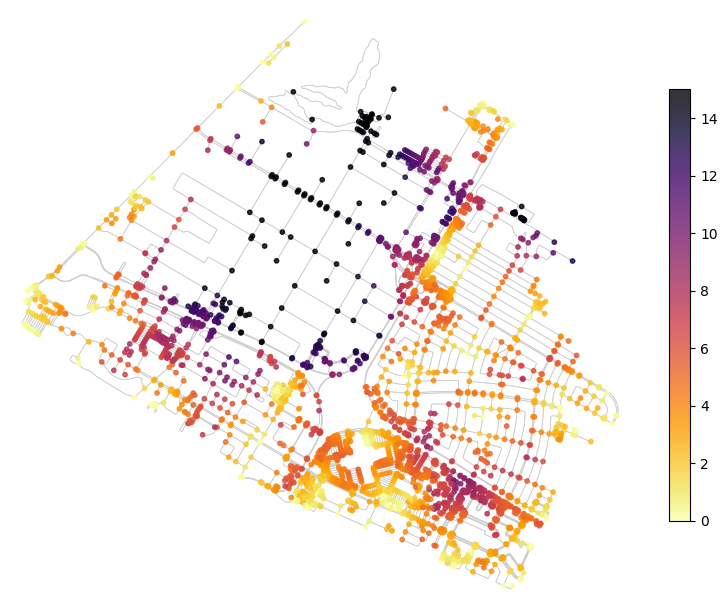

In [35]:
# this graph also has the right celestial projection (north on top)

G = ox.graph_from_place('Anjou, Montreal, Canada', network_type='walk')

# Project the graph to an appropriate CRS
G_proj = ox.project_graph(G)

# Plot the graph with a light background
fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)

# Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

# Scatter plot on the same Axes instance
sc = ax.scatter(x=nodes_proj['x'], y=nodes_proj['y'], c=distances_anjou_restaurant['travel_time'], s=10, cmap='inferno_r', alpha=0.8)

# Add colorbar
plt.colorbar(sc, ax=ax, shrink=0.7)

# Show the plot
plt.show()